# Datasets

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
import os
import warnings

import torch

os.chdir("../..")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 8
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)

## 1D Gaussian Process Datasets

A good way to compare members of the NPFs is by trying to model samples from different Gaussian processes.
Specifically, we will investigate NPFs in the following three settings:

1. **Samples from a single GP** the first question we want to understand is how well NPFs can model a ground truth GP. To test this hypothesis, we will repeatedly sample from a single GP and then compare the posterior predictive to the ground truth GP. Note that this is not really a natural setting, but the goal is to understand how biased the objective is and which NPF can best approximate the ground truth GP with finite computation. We will
    * Training : 100 epochs, each epoch consists of 10k different context and target sets from the GP (never see the same example twice)
    * Datasets : 3 datasets, each corresponding to a GP with a different kernel with fixed hyper-parameters. Namely : [RBF](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html), [Exp-Sine-Squared (periodic)](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html), [Matern](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern) with [noise](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html#sklearn.gaussian_process.kernels.WhiteKernel). 
    * Evaluation : compare to the ground truth GP
   
   
2. **Samples from GPs with varying Kernels** in the second experiment will investigate whether members of the NPF can model a ground truth GP even it was trained on samples from different kernels. I.e. if it can "recognize" the kernel and model the ground truth GP once it does. To do so we will simply train on the 3 datasets from the first point. 
    * Training : 100 epochs, each epoch consists of 10k different context and target sets from the GP (never see the same example twice)
    * Datasets : union of the 3 datasets from the first point
    * Evaluation : evaluate on each 3 datasets separately and compare to the ground truth GP


3. **Samples from GPs with varying Kernel hyperparameters** finally we will test whether the NPFs can model a family of GPs. 
    * Training : 100 epochs, each epoch consists of 10k different context and target sets from the GP (never see the same example twice)
    * Datasets : Data generated by sampling a length scale $[0.01, 0.3]$ and then a function from a GP with Matern kernel and the corresponding length scale
    * Evaluation : compare to a GP with Matern Kernel, with a length scale fitted on the context points (using the marginal likelihood)
    

**Extensions**

- See the docstrings of `GPDataset` for more parameters. 
- Adding a dataset from a new kernel is straightforward by defining your own [kernel](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes) and following the same step as below.


In [2]:
# GPDataset Docstring
from utils.data import GPDataset

print(GPDataset.__doc__)


    Dataset of functions generated by a gaussian process.

    Parameters
    ----------
    kernel : sklearn.gaussian_process.kernels or list
        The kernel specifying the covariance function of the GP. If None is
        passed, the kernel "1.0 * RBF(1.0)" is used as default.

    min_max : tuple of floats, optional
        Min and max point at which to evaluate the function (bounds).

    n_samples : int, optional
        Number of sampled functions contained in dataset.

    n_points : int, optional
        Number of points at which to evaluate f(x) for x in min_max.

    is_vary_kernel_hyp : bool, optional
        Whether to sample each example from a kernel with random hyperparameters,
        that are sampled uniformly in the kernel hyperparameters `*_bounds`.

    save_file : string or tuple of strings, optional
        Where to save and load the dataset. If tuple `(file, group)`, save in
        the hdf5 under the given group. If `None` regenerate samples indefinitely.
  

(samples_from_gp)=
### Samples from a single GP

In [3]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Matern, WhiteKernel

from utils.ntbks_helpers import get_gp_datasets


def get_datasets_single_gp():
    """Return train / tets / valid sets for 'Samples from a single GP'."""
    kernels = dict()

    kernels["RBF_Kernel"] = RBF(length_scale=(0.2))

    kernels["Periodic_Kernel"] = ExpSineSquared(length_scale=1, periodicity=0.5)

    #kernels["Matern_Kernel"] = Matern(length_scale=0.2, nu=1.5)

    kernels["Noisy_Matern_Kernel"] = WhiteKernel(noise_level=0.1) + Matern(
        length_scale=0.2, nu=1.5
    )

    return get_gp_datasets(
        kernels,
        is_vary_kernel_hyp=False,  # use a single hyperparameter per kernel
        n_samples=50000,  # number of different context-target sets
        n_points=128,  # size of target U context set for each sample
        is_reuse_across_epochs=False,  # never see the same example twice
    )


# create the dataset and store it (if not already done)
(datasets, _, __,) = get_datasets_single_gp()

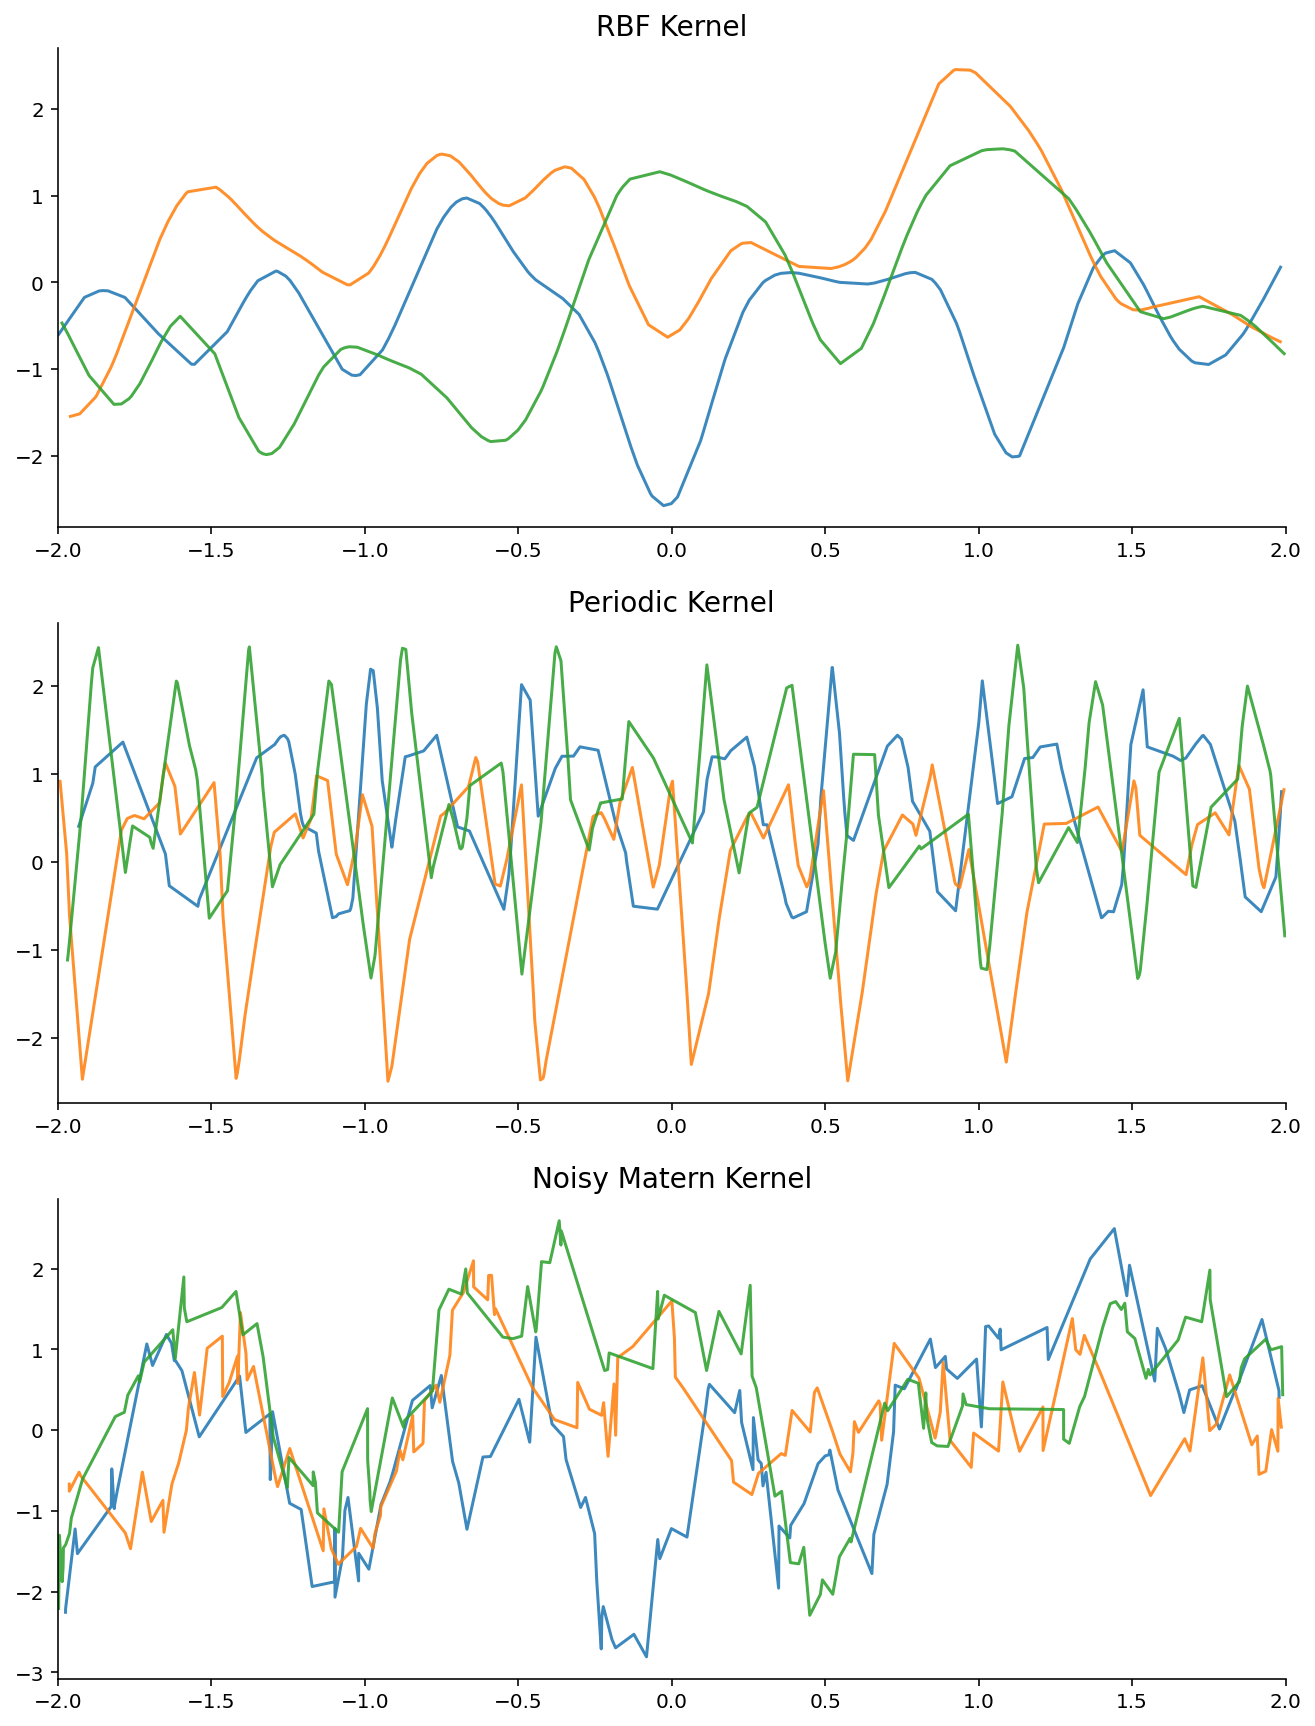

In [4]:
import matplotlib.pyplot as plt

from utils.visualize import plot_dataset_samples_1d

n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5 * n_datasets), squeeze=False)
for i, (k, dataset) in enumerate(datasets.items()):
    plot_dataset_samples_1d(dataset, title=k.replace("_", " "), ax=axes.flatten()[i], n_samples=3)

### Samples from GPs with varying Kernels

In [5]:
from utils.data.helpers import DatasetMerger


def get_datasets_varying_kernel_gp():
    """Return train / tets / valid sets for 'Samples from GPs with varying Kernels'."""

    datasets, test_datasets, valid_datasets = get_datasets_single_gp()
    return (
        dict(All_Kernels=DatasetMerger(datasets.values())),
        dict(All_Kernels=DatasetMerger(test_datasets.values())),
        dict(All_Kernels=DatasetMerger(valid_datasets.values())),
    )


# create the dataset and store it (if not already done)
(datasets, _, __,) = get_datasets_varying_kernel_gp()

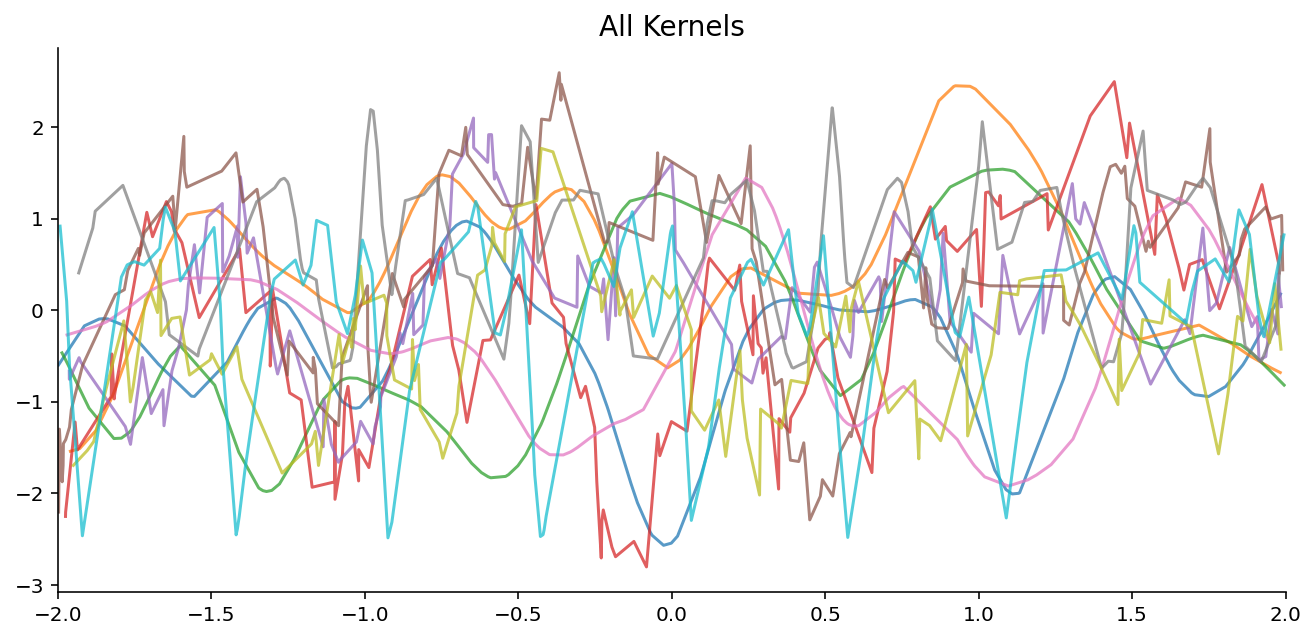

In [6]:
n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5 * n_datasets), squeeze=False)
for i, (k, dataset) in enumerate(datasets.items()):
    plot_dataset_samples_1d(dataset, title=k.replace("_", " "), ax=axes.flatten()[i], n_samples=10)

### Samples from GPs with varying Kernel hyperparameters

In [7]:
def get_datasets_variable_hyp_gp():
    """Return train / tets / valid sets for 'Samples from GPs with varying Kernel hyperparameters'."""
    kernels = dict()

    kernels["Variable_Matern_Kernel"] = Matern(length_scale_bounds=(0.01, 0.3), nu=1.5)

    return get_gp_datasets(
        kernels,
        is_vary_kernel_hyp=True,  # use a single hyperparameter per kernel
        n_samples=50000,  # number of different context-target sets
        n_points=128,  # size of target U context set for each sample
        is_reuse_across_epochs=False,  # never see the same example twice
    )



# create the dataset and store it (if not already done)
(datasets, _, __,) = get_datasets_variable_hyp_gp()

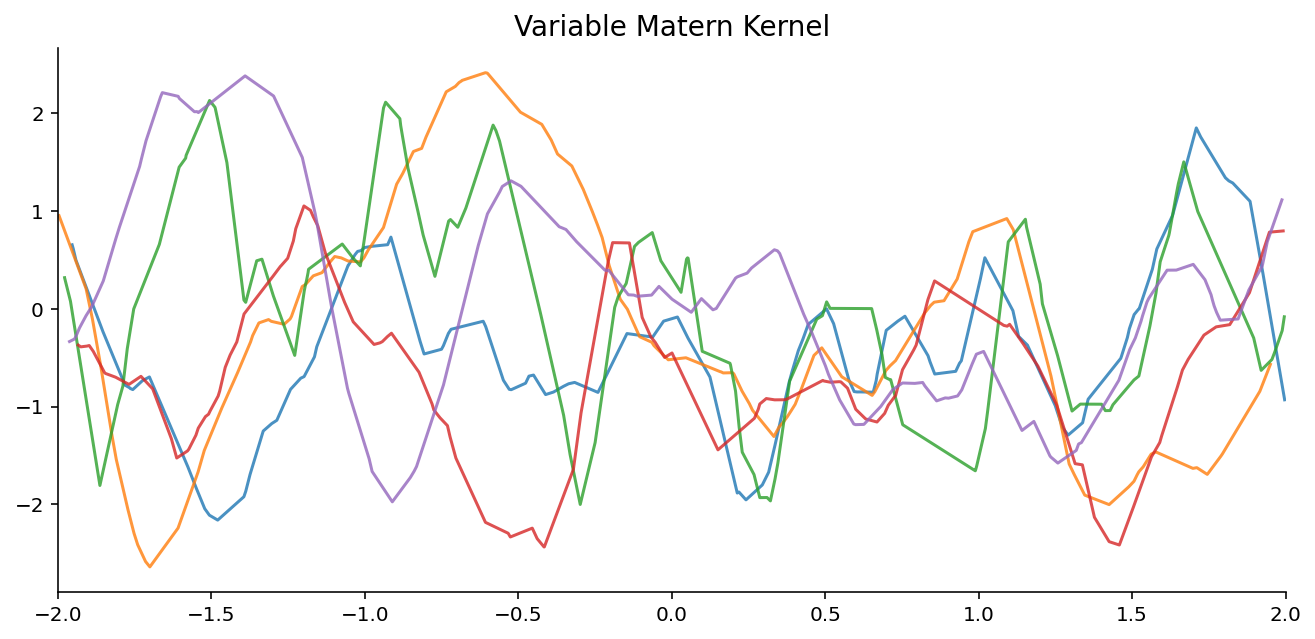

In [8]:
n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5 * n_datasets), squeeze=False)
for i, (k, dataset) in enumerate(datasets.items()):
    plot_dataset_samples_1d(dataset, title=k.replace("_", " "), ax=axes.flatten()[i], n_samples=5)

## Image Datasets

We will be using the following datasets

- MNIST {cite}`lecun1998gradient`
- CelebA {cite}`liu2018large` (rescaled to $32 \times 32$ pixels)
- Zero Shot Multi MNIST {cite}`gordon2019convolutional` (ZSMM). 

```{note}
We will follow {cite}`foong2020convnp` for ZSMM. Namely, train on translated MNIST and test on a larger canvas with multiple digits (ZSMM).
```

In [9]:
from utils.data import get_train_test_img_dataset

datasets = dict()
_, datasets["CelebA32"] = get_train_test_img_dataset("celeba32")
_, datasets["MNIST"] = get_train_test_img_dataset("mnist")

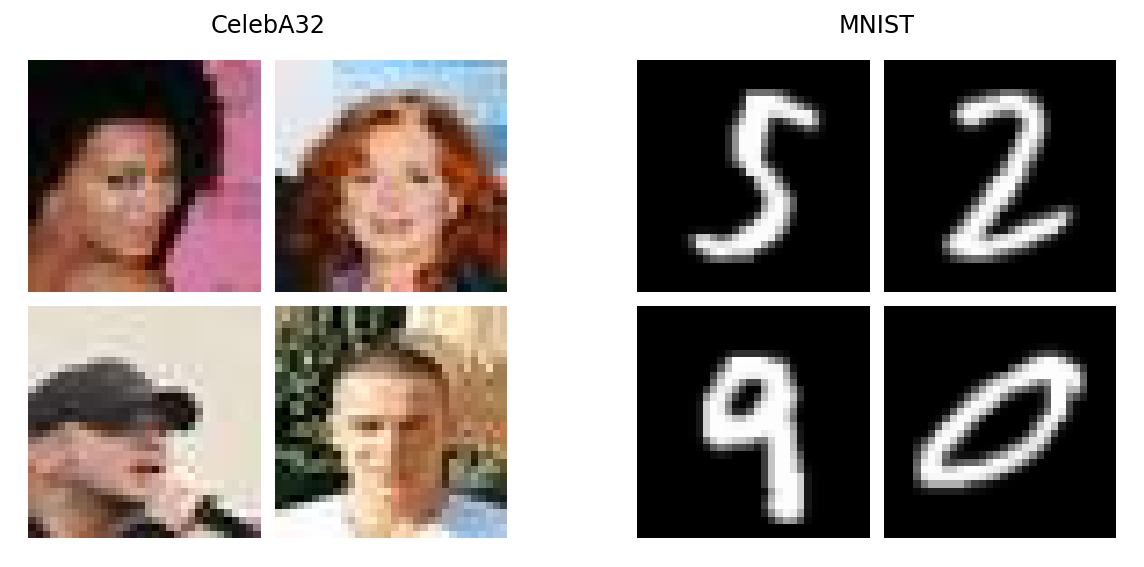

In [10]:
from utils.visualize import plot_dataset_samples_imgs

n_datasets = len(datasets)
fig, axes = plt.subplots(1, n_datasets, figsize=(5 * n_datasets, 5))
for i, (k, dataset) in enumerate(datasets.items()):
    plot_dataset_samples_imgs(dataset, title=k, ax=axes[i])

Let us now visualize some training and testing samples from ZSMM:

In [11]:
datasets_zsmm = dict()
datasets_zsmm["ZSMM Train"], datasets_zsmm["ZSMM Test"] = get_train_test_img_dataset("zsmms")

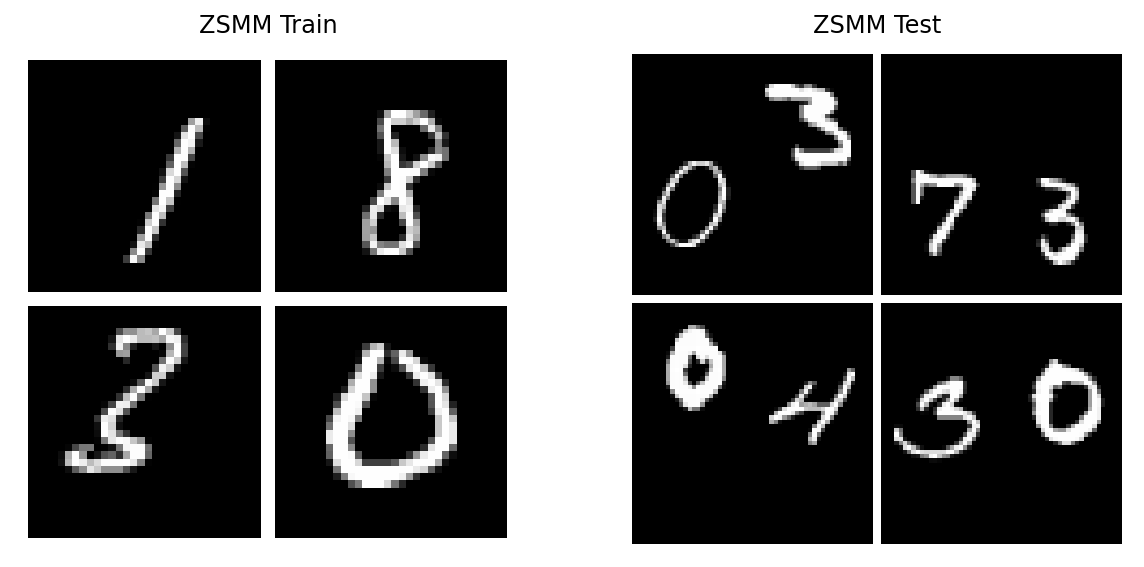

In [12]:
from utils.visualize import plot_dataset_samples_imgs

n_datasets = len(datasets_zsmm)
fig, axes = plt.subplots(1, n_datasets, figsize=(5 * n_datasets, 5))
for i, (k, dataset) in enumerate(datasets_zsmm.items()):
    plot_dataset_samples_imgs(dataset, title=k, ax=axes[i])